## Discretisation

Discretisation is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable's values. Discretisation is also called **binning**, where bin is an alternative name for interval.

### Discretisation helps handle outliers and may improve value spread in skewed variables

Discretisation helps handle outliers by placing these values into the lower or higher intervals, together with the remaining inlier values of the distribution. Thus, these outlier observations no longer differ from the rest of the values at the tails of the distribution, as they are now all together in the same interval / bucket. In addition, by creating appropriate bins or intervals, discretisation can help spread the values of a skewed variable across a set of bins with equal number of observations.


### Discretisation approaches

There are several approaches to transform continuous variables into discrete ones. Discretisation methods fall into 2 categories: **supervised and unsupervised**. Unsupervised methods do not use any information, other than the variable distribution, to create the contiguous bins in which the values will be placed. Supervised methods typically use target information in order to create the bins or intervals.


####  Unsupervised discretisation methods

- Equal width discretisation
- Equal frequency discretisation
- K-means discretisation

#### Supervised discretisation methods

- Discretisation using decision trees

# 1. Equal width discretisation

Equal width discretisation divides the scope of possible values into N bins of the same width.The width is determined by the range of values in the variable and the number of bins we wish to use to divide the variable:

width = (max value - min value) / N

where N is the number of bins or intervals.

For example if the values of the variable vary between 0 and 100, we create 5 bins like this: width = (100-0) / 5 = 20. The bins thus are 0-20, 20-40, 40-60, 80-100. The first and final bins (0-20 and 80-100) can be expanded to accommodate outliers (that is, values under 0 or greater than 100 would be placed in those bins as well).

There is no rule of thumb to define N, that is something to determine experimentally.

In [1]:
# !pip install feature-engine

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
# load the numerical variables of the Titanic Dataset
data = pd.read_csv('./data/titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Age', 'Fare']],
    data['Survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((623, 2), (268, 2))

The variables Age and fare contain missing data, that I will fill by extracting a random sample of the variable.

In [6]:
def impute_na(data, variable):

    df = data.copy()

    # random sampling
    df[variable + '_random'] = df[variable]

    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable + '_random'] = random_sample

    return df[variable + '_random']

In [7]:
# replace NA in both  train and test sets

X_train['Age'] = impute_na(data, 'Age')
X_test['Age'] = impute_na(data, 'Age')

X_train['Fare'] = impute_na(data, 'Fare')
X_test['Fare'] = impute_na(data, 'Fare')

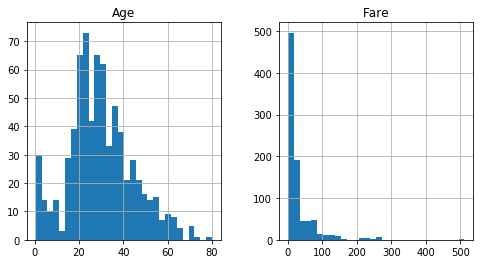

In [8]:
# let's explore the distribution of age

data[['Age', 'Fare']].hist(bins=30, figsize=(8,4))
plt.show()

## 1.1. Equal width discretisation with pandas and NumPy

First we need to determine the intervals' edges or limits.

In [10]:
X_train['Age'].min()

0.67

In [11]:
X_train['Age'].max()

80.0

In [12]:
# let's capture the range of the variable age
age_range = X_train['Age'].max() - X_train['Age'].min()

age_range

79.33

In [13]:
# let's divide the range into 10 equal width bins
age_range / 10

7.933

The range or width of our intervals will be 7 years.

In [14]:
# now let's capture the lower and upper boundaries

min_value = int(np.floor( X_train['Age'].min()))
max_value = int(np.ceil( X_train['Age'].max()))

# let's round the bin width
inter_value = int(np.round(age_range / 10))

min_value, max_value, inter_value

(0, 80, 8)

In [15]:
# let's capture the interval limits, so we can pass them to the pandas cut 
# function to generate the bins

intervals = [i for i in range(min_value, max_value+inter_value, inter_value)]

intervals

[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80]

In [16]:
# let's make labels to label the different bins

labels = ['Bin_' + str(i) for i in range(1, len(intervals))]

labels

['Bin_1',
 'Bin_2',
 'Bin_3',
 'Bin_4',
 'Bin_5',
 'Bin_6',
 'Bin_7',
 'Bin_8',
 'Bin_9',
 'Bin_10']

In [17]:
# create binned age / discretise age

# create one column with labels
X_train['Age_disc_labels'] = pd.cut(x=X_train['Age'],
                                    bins=intervals,
                                    labels=labels,
                                    include_lowest=True)

# and one with bin boundaries
X_train['Age_disc'] = pd.cut(x=X_train['Age'],
                             bins=intervals,
                             include_lowest=True)

X_train.head(10)

,Age,Fare,Age_disc_labels,Age_disc
857,51.0,26.5500,Bin_7,"(48.0, 56.0]"
52,49.0,76.7292,Bin_7,"(48.0, 56.0]"
386,1.0,46.9000,Bin_1,"(-0.001, 8.0]"
124,54.0,77.2875,Bin_7,"(48.0, 56.0]"
578,14.5,14.4583,Bin_2,"(8.0, 16.0]"
549,8.0,36.7500,Bin_1,"(-0.001, 8.0]"
118,24.0,247.5208,Bin_3,"(16.0, 24.0]"
12,20.0,8.0500,Bin_3,"(16.0, 24.0]"
157,30.0,8.0500,Bin_4,"(24.0, 32.0]"
127,24.0,7.1417,Bin_3,"(16.0, 24.0]"


In [22]:
X_train['Age_disc_labels'].nunique()

10

We can see in the above output how by discretising using equal width, we placed each Age observation within one interval / bin. 

When performing equal width discretisation, we guarantee that the intervals are all of the same lenght, however there won't necessarily be the same number of observations in each of the intervals. See below:

In [23]:
X_train.groupby('Age_disc')['Age'].count()

Age_disc
(-0.001, 8.0]     49
(8.0, 16.0]       36
(16.0, 24.0]     147
(24.0, 32.0]     146
(32.0, 40.0]     112
(40.0, 48.0]      68
(48.0, 56.0]      37
(56.0, 64.0]      19
(64.0, 72.0]       7
(72.0, 80.0]       2
Name: Age, dtype: int64

Text(0, 0.5, 'Number of observations per bin')

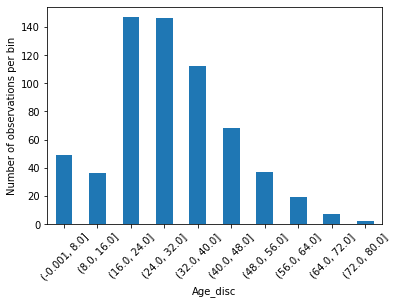

In [24]:
X_train.groupby('Age_disc')['Age'].count().plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

The majority of people on the Titanic were between 14-42 years of age.

Now, we can discretise Age in the test set, using the same interval boundaries that we calculated for the train set:

In [25]:
X_test['Age_disc_labels'] = pd.cut(x=X_test['Age'],
                                   bins=intervals,
                                   labels=labels,
                                   include_lowest=True)

X_test['Age_disc'] = pd.cut(x=X_test['Age'],
                            bins=intervals,
                            include_lowest=True)

X_test.head()

,Age,Fare,Age_disc_labels,Age_disc
495,42.0,14.4583,Bin_6,"(40.0, 48.0]"
648,18.0,7.5500,Bin_3,"(16.0, 24.0]"
278,7.0,29.1250,Bin_1,"(-0.001, 8.0]"
31,35.0,146.5208,Bin_5,"(32.0, 40.0]"
255,29.0,15.2458,Bin_4,"(24.0, 32.0]"


Text(0, 0.5, 'Number of observations per bin')

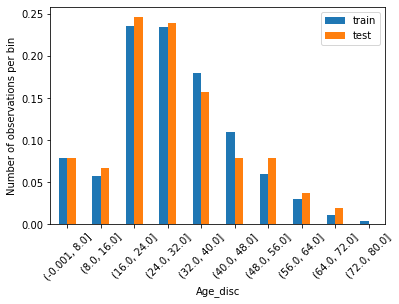

In [26]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set
# let's see that below

t1 = X_train.groupby(['Age_disc'])['Age'].count() / len(X_train)
t2 = X_test.groupby(['Age_disc'])['Age'].count() / len(X_test)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

## 1.2. Equal width discretisation with Feature-Engine

In [27]:
from feature_engine.discretisation import EqualWidthDiscretiser

In [28]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Age', 'Fare']],
    data['Survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((623, 2), (268, 2))

In [29]:
# replace NA in both  train and test sets

X_train['Age'] = impute_na(data, 'Age')
X_test['Age'] = impute_na(data, 'Age')

X_train['Fare'] = impute_na(data, 'Fare')
X_test['Fare'] = impute_na(data, 'Fare')

In [30]:
# with feature engine we can automate the process for many variables
# in one line of code

disc = EqualWidthDiscretiser(bins=10, variables = ['Age', 'Fare'])

disc.fit(X_train)

EqualWidthDiscretiser(variables=['Age', 'Fare'])

In [32]:
# in the binner dict, we can see the limits of the intervals. For age
# the value increases aproximately 8 years from one bin to the next.

# for fare it increases in around 51 dollars from one interval to the 
# next, but it increases always the same value, aka, same width.

disc.binner_dict_

{'Age': [-inf,
  8.603,
  16.536,
  24.469,
  32.402,
  40.335,
  48.268,
  56.201,
  64.134,
  72.067,
  inf],
 'Fare': [-inf,
  51.23292,
  102.46584,
  153.69876,
  204.93168,
  256.1646,
  307.39752,
  358.63044,
  409.86336,
  461.09628,
  inf]}

In [33]:
# transform train and text

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [34]:
train_t.head()

,Age,Fare
857,6,0
52,6,1
386,0,0
124,6,1
578,1,0


Text(0, 0.5, 'Number of observations per bin')

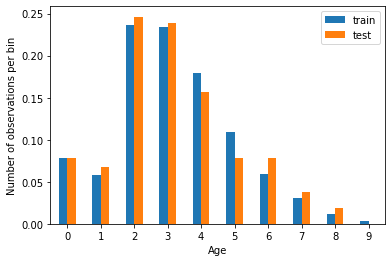

In [35]:
t1 = train_t.groupby(['Age'])['Age'].count() / len(train_t)
t2 = test_t.groupby(['Age'])['Age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

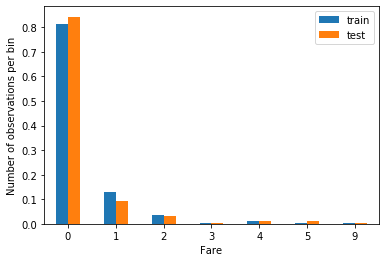

In [36]:
t1 = train_t.groupby(['Fare'])['Fare'].count() / len(train_t)
t2 = test_t.groupby(['Fare'])['Fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

We can see quite clearly, that equal width discretisation does not improve the value spread. The original variable Fare was skewed, and the discrete variable is also skewed.

## 1.3. Equal width discretisation with Scikit-learn

In [37]:
from sklearn.preprocessing import KBinsDiscretizer

In [38]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Age', 'Fare']],
    data['Survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((623, 2), (268, 2))

In [39]:
# replace NA in both  train and test sets

X_train['Age'] = impute_na(data, 'Age')
X_test['Age'] = impute_na(data, 'Age')

X_train['Fare'] = impute_na(data, 'Fare')
X_test['Fare'] = impute_na(data, 'Fare')

In [40]:
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

disc.fit(X_train[['Age', 'Fare']])

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')

In [41]:
disc.bin_edges_

array([array([ 0.67 ,  8.603, 16.536, 24.469, 32.402, 40.335, 48.268, 56.201,
              64.134, 72.067, 80.   ])                                       ,
       array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
              307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ])          ],
      dtype=object)

In [42]:
train_t = disc.transform(X_train[['Age', 'Fare']])

train_t = pd.DataFrame(train_t, columns = ['Age', 'Fare'])

train_t.head()

,Age,Fare
0,6.0,0.0
1,6.0,1.0
2,0.0,0.0
3,6.0,1.0
4,1.0,0.0


In [43]:
test_t = disc.transform(X_test[['Age', 'Fare']])

test_t = pd.DataFrame(test_t, columns = ['Age', 'Fare'])

Text(0, 0.5, 'Number of observations per bin')

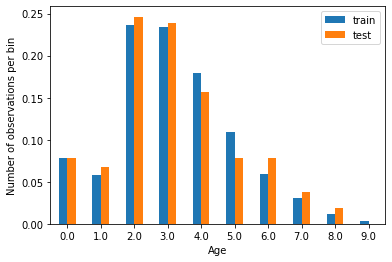

In [44]:
t1 = train_t.groupby(['Age'])['Age'].count() / len(train_t)
t2 = test_t.groupby(['Age'])['Age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

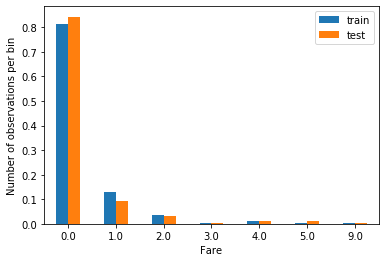

In [45]:
t1 = train_t.groupby(['Fare'])['Fare'].count() / len(train_t)
t2 = test_t.groupby(['Fare'])['Fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

# 2. Equal frequency discretisation with Feature-Engine

In [46]:
from feature_engine.discretisation import EqualFrequencyDiscretiser

In [47]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Age', 'Fare']],
    data['Survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((623, 2), (268, 2))

In [48]:
# replace NA in both  train and test sets

X_train['Age'] = impute_na(data, 'Age')
X_test['Age'] = impute_na(data, 'Age')

X_train['Fare'] = impute_na(data, 'Fare')
X_test['Fare'] = impute_na(data, 'Fare')

In [49]:
# with feature engine we can automate the process for many variables
# in one line of code

disc = EqualFrequencyDiscretiser(q=10, variables = ['Age', 'Fare'])

disc.fit(X_train)

EqualFrequencyDiscretiser(variables=['Age', 'Fare'])

In [50]:
# in the binner dict, we can see the limits of the intervals. Note
# that the intervals have different widths

disc.binner_dict_

{'Age': [-inf,
  13.200000000000003,
  19.0,
  22.0,
  26.0,
  29.0,
  32.0,
  36.0,
  41.60000000000002,
  49.0,
  inf],
 'Fare': [-inf,
  7.72584,
  7.88252,
  8.05,
  12.130000000000008,
  15.0,
  23.45,
  27.75,
  46.9,
  77.17584000000004,
  inf]}

In [51]:
# transform train and text

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [52]:
train_t.head()

,Age,Fare
857,9,6
52,8,8
386,0,7
124,9,9
578,1,4


Text(0, 0.5, 'Number of observations per bin')

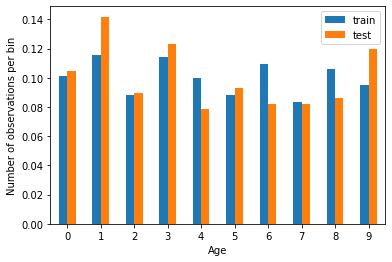

In [53]:
# and now let's explore the number of observations per bucket

t1 = train_t.groupby(['Age'])['Age'].count() / len(train_t)
t2 = test_t.groupby(['Age'])['Age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

We can see that the top intervals have less observations. This may happen with skewed distributions if we try to divide in a high number of intervals. To make the value spread  more homogeneous, we should discretise in less intervals.

Text(0, 0.5, 'Number of observations per bin')

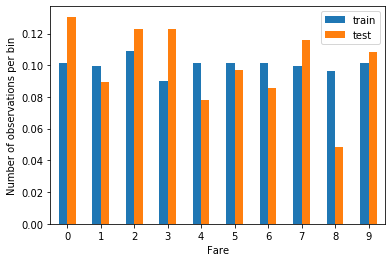

In [54]:
t1 = train_t.groupby(['Fare'])['Fare'].count() / len(train_t)
t2 = test_t.groupby(['Fare'])['Fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Note how equal frequency discretisation obtains a better value spread across the different intervals.

## Equal frequency discretisation with Scikit-learn

In [55]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Age', 'Fare']],
    data['Survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((623, 2), (268, 2))

In [56]:
# replace NA in both  train and test sets

X_train['Age'] = impute_na(data, 'Age')
X_test['Age'] = impute_na(data, 'Age')

X_train['Fare'] = impute_na(data, 'Fare')
X_test['Fare'] = impute_na(data, 'Fare')

In [57]:
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

disc.fit(X_train[['Age', 'Fare']])

KBinsDiscretizer(encode='ordinal', n_bins=10)

In [58]:
disc.bin_edges_

array([array([ 0.67, 13.2 , 19.  , 22.  , 26.  , 29.  , 32.  , 36.  , 41.6 ,
              49.  , 80.  ])                                                ,
       array([  0.     ,   7.72584,   7.88252,   8.05   ,  12.13   ,  15.     ,
               23.45   ,  27.75   ,  46.9    ,  77.17584, 512.3292 ])          ],
      dtype=object)

In [59]:
train_t = disc.transform(X_train[['Age', 'Fare']])

train_t = pd.DataFrame(train_t, columns = ['Age', 'Fare'])

train_t.head()

,Age,Fare
0,9.0,6.0
1,9.0,8.0
2,0.0,8.0
3,9.0,9.0
4,1.0,4.0


In [60]:
test_t = disc.transform(X_test[['Age', 'Fare']])

test_t = pd.DataFrame(test_t, columns = ['Age', 'Fare'])

Text(0, 0.5, 'Number of observations per bin')

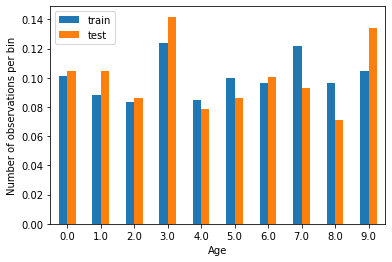

In [61]:
t1 = train_t.groupby(['Age'])['Age'].count() / len(train_t)
t2 = test_t.groupby(['Age'])['Age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

# 3. Discretisation-using-Decision-Trees-and-Feature-Engine

In [62]:
from feature_engine.discretisation import DecisionTreeDiscretiser

In [63]:
# set up the decision tree discretiser indicating:
# cross-validation number (cv)
# how to evaluate model performance (scoring)
# the variables we want to discretise (variables)
# whether it is a target for regression or classification
# and the grid with the parameters we want to test

treeDisc = DecisionTreeDiscretiser(cv=10, scoring='accuracy',
                                   variables=['Age', 'Fare'],
                                   regression=False,
                                   param_grid={'max_depth': [1, 2, 3],
                                              'min_samples_leaf':[10,4]})

treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(cv=10,
                        param_grid={'max_depth': [1, 2, 3],
                                    'min_samples_leaf': [10, 4]},
                        regression=False, scoring='accuracy',
                        variables=['Age', 'Fare'])

In [64]:
# we can inspect the tree for age
treeDisc.binner_dict_['Age'].best_params_

{'max_depth': 3, 'min_samples_leaf': 10}

In [65]:
# and the performance obtained on the train set while fitting
treeDisc.scores_dict_['Age']

0.6324237560192616

In [66]:
# and the best parameters for fare
treeDisc.binner_dict_['Fare'].best_params_

{'max_depth': 2, 'min_samples_leaf': 10}

In [67]:
# and the performance obtained on the train set while fitting

treeDisc.scores_dict_['Fare']

0.6645264847512039

By comparing the accuracy of the decision trees for age and fare, we can derive that fare is a better indicator of the outcome survived.

In [70]:
X_train

,Age,Fare
857,51.0,26.5500
52,49.0,76.7292
386,1.0,46.9000
124,54.0,77.2875
578,14.5,14.4583
...,...,...
835,39.0,83.1583
192,19.0,7.8542
629,29.0,7.7333
559,36.0,17.4000


In [71]:
# let's transform the data

train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

In [72]:
train_t

,Age,Fare
857,0.392045,0.442308
52,0.392045,0.746269
386,0.750000,0.442308
124,0.392045,0.746269
578,0.818182,0.442308
...,...,...
835,0.392045,0.746269
192,0.331579,0.255319
629,0.392045,0.255319
559,0.392045,0.442308


In [69]:
# let's inspect how many bins we found

train_t['Age'].unique()

array([0.39204545, 0.75      , 0.81818182, 0.45833333, 0.33157895,
       0.1       ])

Text(0, 0.5, 'Survived')

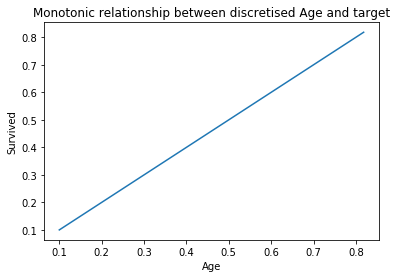

In [73]:
# monotonic relationship with target: train set

pd.concat([train_t, y_train], axis=1).groupby(['Age'])['Survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

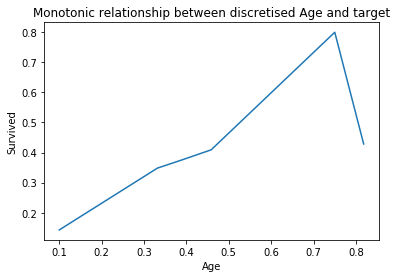

In [74]:
# monotonic relationship with target: test set

pd.concat([test_t, y_test], axis=1).groupby(['Age'])['Survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Our tree kept the monotonic relationship between bins and target.

Text(0, 0.5, 'Survived')

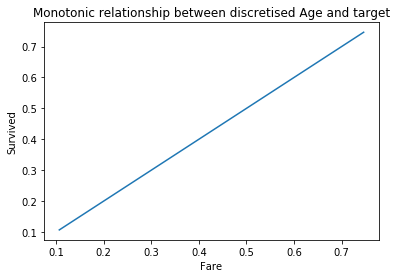

In [75]:
# let's explore the monotonic relationship for fare
pd.concat([train_t, y_train], axis=1).groupby(['Fare'])['Survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

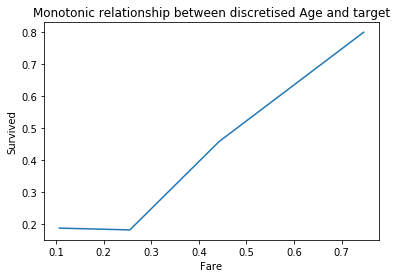

In [76]:
# monotonic relationship with target: test set

pd.concat([test_t, y_test], axis=1).groupby(['Fare'])['Survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

For fare, the monotonic relationship was preserved, almost entirely, except at the edges, which suggests that the tree could be overfitting to the train set.

Text(0, 0.5, 'Number of observations per bin')

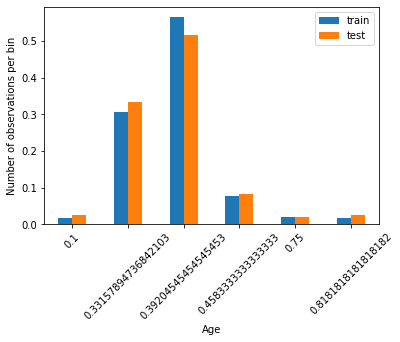

In [77]:
# let's explore how many observations we have per bin

t1 = train_t.groupby(['Age'])['Age'].count() / len(train_t)
t2 = test_t.groupby(['Age'])['Age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

Most of the observations are in the middle bucket, which indicates that this variable is not very predictive. 

Text(0, 0.5, 'Number of observations per bin')

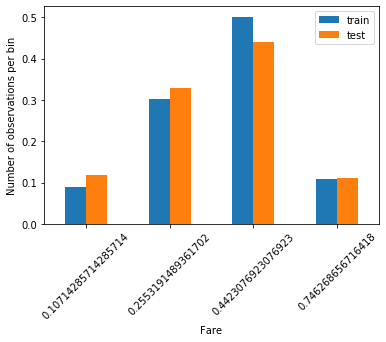

In [78]:
# let's explore how many observations we have per bin

t1 = train_t.groupby(['Fare'])['Fare'].count() / len(train_t)
t2 = test_t.groupby(['Fare'])['Fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

For fare, the tree sorted the values in more buckets, therefore creating a better value spread (remember that fare was quite skewed).